## Coronagraphy simulations with MIRAGE using the ETC

This notebook generates simulated NIRCam coronagraphy observations using a seed image made with the ETC detector FITS file download and corresponding JSON file.

This notebook was created with the help of the example notebooks in the MIRAGE repository: https://github.com/spacetelescope/nircam_simulator

### Table of Contents:
> #### 1. [MIRAGE image simulation overview](#overview)
> #### 2. [Imports](#imports)
> #### 3. [Use the ETC outputs as seed images (target and PSF reference)](#etc)
> #### 4. [Load the ETC JSON file](#json)
> #### 5. [Preparing the image to be input into MIRAGE](#prepare)
> #### 6. [Use the JSON file to create the MIRAGE config files](#yaml)
> #### 7. [Initialize the seed image](#seed)
> #### 8. [Prepare the dark current exposure](#dark)
> #### 9. [Create the final simlated exposures](#simulation)
> #### 10. [Check out the simulated output linearized exposures](#examine)
> #### 11. [Use the Stage 1 pipeline to generate slope images](#pipeline)
> #### 12. [Run Stage 2 steps on the Stage 1 outputs](#stage2)
> #### 13. [Run Stage 3 (coronagraphy pipeline) on the Stage 2 outputs](#stage3)

***
<a id='overview'></a>
## 1. MIRAGE image simulation overview



The simulator is broken up into three basic stages:

>1. __Creation of a "seed image".__ This is generally a noiseless countrate image that contains signal only from the astronomical sources to be simulated. Currently, the nircam_simulator package contains code to produce a seed image starting from object catalogs, but we can get around this by substituting our ETC detector image at the appropriate step.
>2. __Dark current prep.__ The simualted data will be created by adding the simulated sources in the seed image to a real NIRCam dark current exposure. This step converts the dark current exposure to the requested readout pattern and subarray size requested by the user.
>3. __Observation generator.__ This step converts the seed image into an exposure with the requested readout pattern and subarray size. It also adds cosmic rays and Poisson noise, as well as other detector effects (IPC, crosstalk, etc). This exposure is then added to the dark current exposure from step 2. 

To read more about MIRAGE, visit the repository here: https://github.com/spacetelescope/nircam_simulator

***
<a id='imports'></a>
## 2. Imports

In [1]:
# Set the NIRCAM_SIM_DATA environment variable if it is not
# set already (for users at STScI)
import os
os.environ['NIRCAM_SIM_DATA'] = '/ifs/jwst/wit/nircam/mirage_data'

# Import the three steps of the simulator.
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.utils import read_fits, utils, siaf_interface

# For extracting the subarray
import pysiaf
from pysiaf import iando
from pysiaf.constants import JWST_DELIVERY_DATA_ROOT

# For pulling the latest gain reference file
import crds
from crds.matches import find_match_paths_as_dict as ref_matches
from crds import getrecommendations

# For examining outputs
import yaml
import json
import random
import numpy as np
from glob import glob
from scipy.stats import sigmaclip
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
%matplotlib inline

In [2]:
# convenience functions
def show(array,title,min=0,max=1000,unit='e$^{-}$'):
    ''' Image plotting convenience function.'''
    plt.figure(figsize=(10,10))
    plt.imshow(array,clim=(min,max),cmap=plt.get_cmap('gray'))
    plt.title(title,fontsize=15)
    plt.axis('off')
    plt.colorbar().set_label(unit+'/s',size=15)
    
def get_instance(instrument):
    """Return an instance of a pysiaf.Siaf object for the given instrument
    Parameters
    ----------
    instrument : str
        Name of instrument
    Returns
    -------
    siaf : pysiaf.Siaf
        Siaf object for the requested instrument
        
    Note: This was pulled from Mirage
    """
    if instrument.lower() == 'nircam':
        print("NOTE: Using pre-delivery SIAF data for {}".format(instrument))
        siaf_instrument = 'NIRCam'
        pre_delivery_dir = os.path.join(JWST_DELIVERY_DATA_ROOT, 'NIRCam')
        siaf = pysiaf.Siaf(siaf_instrument, basepath=pre_delivery_dir)
    else:
        siaf_instrument = instrument
        siaf = pysiaf.Siaf(siaf_instrument)
    return siaf    

***
<a id='etc'></a>
## 3. Use the ETC outputs as seed images (target and PSF reference)

<div class="alert alert-block alert-warning">Note: This image was generated using standard ETC configurations and outputs. Future versions will exclude noise sources, since these are added as part of MIRAGE simulations.</div>

In [3]:
star_base = "Star_1planet"
psf_base = "PSF_ref"

img_e = fits.getdata(star_base+".fits")
imgheader_e = fits.getheader(star_base+".fits")

psf_e = fits.getdata(psf_base+".fits")
psfheader_e = fits.getheader(psf_base+".fits")

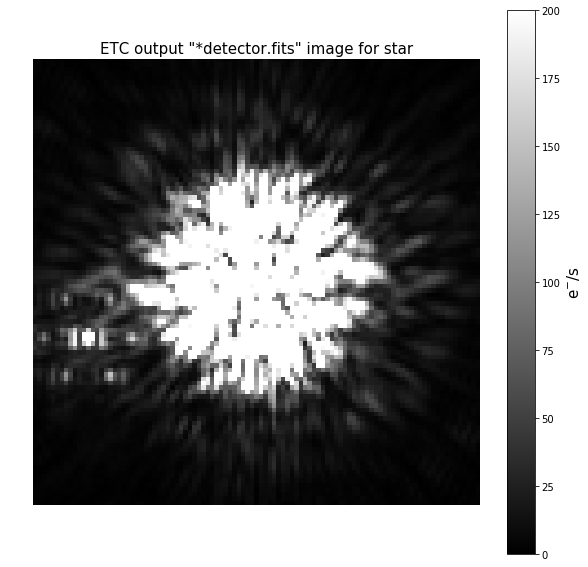

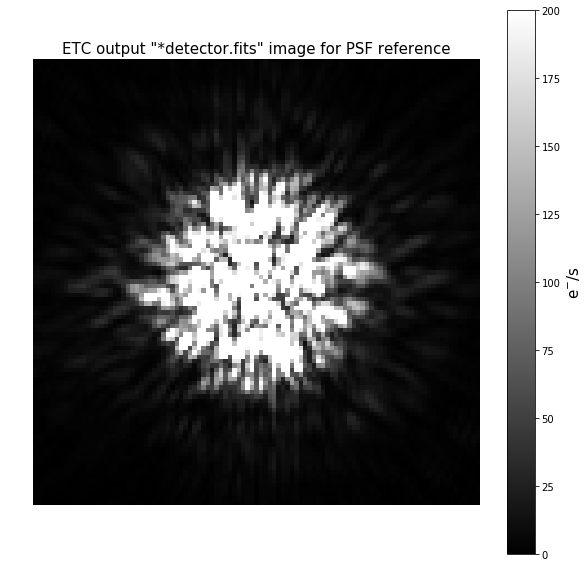

In [4]:
show(img_e,'ETC output "*detector.fits" image for star',max=200)
show(psf_e,'ETC output "*detector.fits" image for PSF reference',max=200)

***
<a id='json'></a>
## 4. Load the ETC JSON file

In [5]:
# The PSF reference and input star JSON files from the ETC 
# are exactly the same for this case, except for "psf_subtraction" 
# in the "strategy" section, so we just use the star's JSON file 

psf_json_file = psf_base+".json"
json_file = star_base+".json"

In [6]:
import pprint
with open(psf_json_file) as f:
    psf_configuration = json.load(f)

with open(json_file) as f:
    configuration = json.load(f)
    
print(psf_configuration['strategy']['psf_subtraction'])
print(configuration['strategy']['psf_subtraction'])

psf_only
target_only


### We will need some things from the JSON file for later

In [7]:
detector = "NRCA5"
subarray = configuration['configuration']['detector']['subarray']
mask = configuration['configuration']['instrument']['aperture']
siafaper = detector+"_"+mask.upper()
ra = 0
dec = 0
rotation = 0

***
<a id='prepare'></a>
## 5. Preparing the image to be input into MIRAGE

To use the detector image to simulate a coronagraphic observation using MIRAGE, we need to make a couple of changes to the image.
* the size of the image must match the given subarray size (the ETC image is 101 x 101 pixels)
* the image location needs to be placed within the correct subarray
* the units need to be changed from __e$^{-}$/sec__ to __ADU/sec__

### Grab gain reference file to convert to ADU

We will use CRDS to figure out the right gain reference file.

In [8]:
context = "jwst_0500.pmap"
match_criteria = {'observatory': 'jwst',
                  'META.INSTRUMENT.NAME': 'nircam',
                  'filekind': 'gain',
                  'META.INSTRUMENT.DETECTOR': detector[:4]+'LONG',
                  'META.SUBARRAY.NAME': 'GENERIC',
                  'META.OBSERVATION.DATE': '2015-10-01',
                  'META.OBSERVATION.TIME': '00:00:01'}
recommended_reffile = getrecommendations(match_criteria, 
                                         reftypes=["gain"],
                                         context=context,
                                         fast=True)
reffile_location = "/grp/crds/cache/references/jwst/"

In [9]:
print('Gain file: ',reffile_location+recommended_reffile['gain'])
gain = fits.getdata(reffile_location+recommended_reffile['gain'],1)

Gain file:  /grp/crds/cache/references/jwst/jwst_nircam_gain_0056.fits


### Add image stamp in ADU to a full frame array using subarray locations from the SIAF

In [10]:
star_big_array = np.zeros((2048,2048),dtype='float32')
psf_big_array = np.zeros((2048,2048),dtype='float32')

In [11]:
siaf_inst = 'NIRCam'
instrument_siaf = get_instance(siaf_inst)

# Input arguments are: Instrument, SIAF AperName, RA, Dec, Rotation
aperture_obj, local_roll, attitude_matrix, ffsize, subarray_bounds = siaf_interface.get_siaf_information(instrument_siaf.instrument,siafaper,ra,dec,rotation)
print('Subarray bounds for '+siafaper+': ',subarray_bounds)

NOTE: Using pre-delivery SIAF data for NIRCam
NOTE: Using pre-delivery SIAF data
Subarray bounds for NRCA5_MASK335R:  [485, 1507, 804, 1826]


In [12]:
xstart = subarray_bounds[0]
xend = subarray_bounds[2]
ystart = subarray_bounds[1]
yend = subarray_bounds[-1]

psf_gain_sub = gain[ystart:ystart+psf_e.shape[0],xstart:xstart+psf_e.shape[1]]
psf_img_adu = psf_e/psf_gain_sub

star_gain_sub = gain[ystart:ystart+img_e.shape[0],xstart:xstart+img_e.shape[1]]
star_img_adu = img_e/star_gain_sub

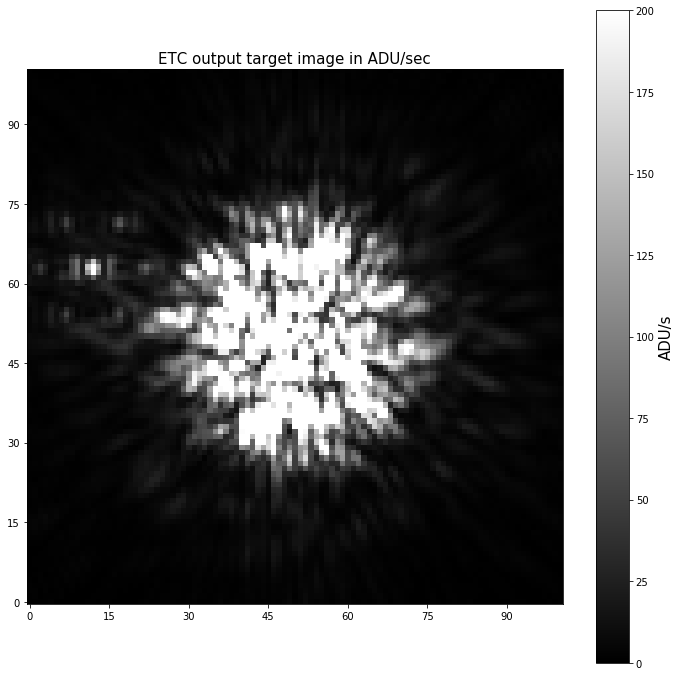

In [13]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(2048)
ys = range(2048)
xlabels = np.arange(0,2048)
ylabels = np.arange(0,2048)

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        

    
plt.imshow(star_img_adu, vmin=0, vmax=200, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('ETC output target image in ADU/sec',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)

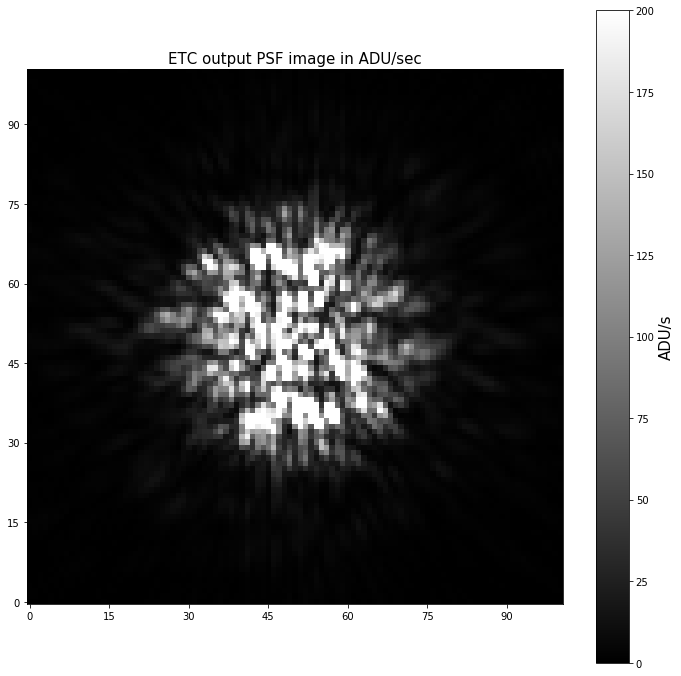

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(2048)
ys = range(2048)
xlabels = np.arange(0,2048)
ylabels = np.arange(0,2048)

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        

    
plt.imshow(psf_img_adu, vmin=0, vmax=200, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('ETC output PSF image in ADU/sec',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)

In [15]:
# place target stamp image inside correct subarray coordinates according to the subarray configuration file
# for both the star and the PSF reference

subsize1 = yend-ystart+1
subsize2 = xend-xstart+1

img_ystart = ystart+int(subsize1/2)-int(star_img_adu.shape[0]/2)
img_xstart = xstart+int(subsize2/2)-int(star_img_adu.shape[1]/2)
img_yend = ystart+int(subsize1/2)+int(star_img_adu.shape[0]/2)+1
img_xend = xstart+int(subsize2/2)+int(star_img_adu.shape[1]/2)+1

star_big_array[img_ystart:img_yend,img_xstart:img_xend] = star_img_adu

psf_img_ystart = ystart+int(subsize1/2)-int(psf_img_adu.shape[0]/2)
psf_img_xstart = xstart+int(subsize2/2)-int(psf_img_adu.shape[1]/2)
psf_img_yend = ystart+int(subsize1/2)+int(psf_img_adu.shape[0]/2)+1
psf_img_xend = xstart+int(subsize2/2)+int(psf_img_adu.shape[1]/2)+1

psf_big_array[psf_img_ystart:psf_img_yend,psf_img_xstart:psf_img_xend] = psf_img_adu

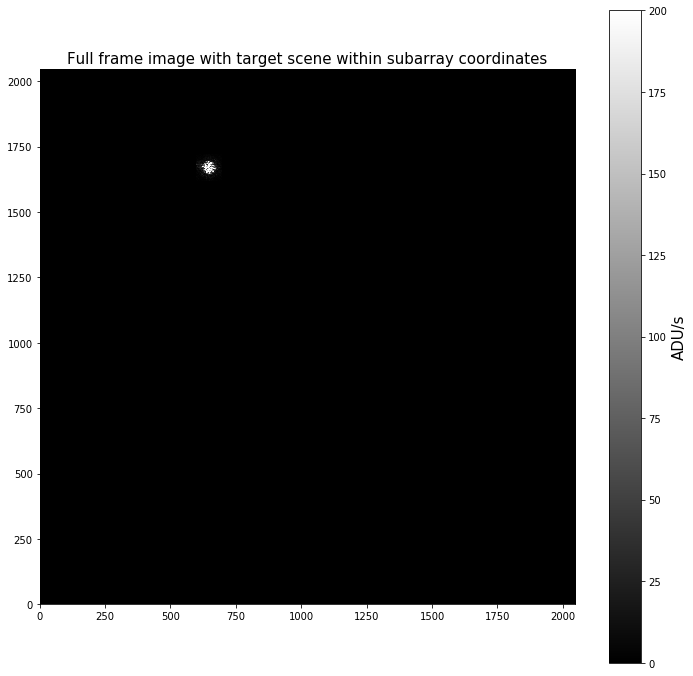

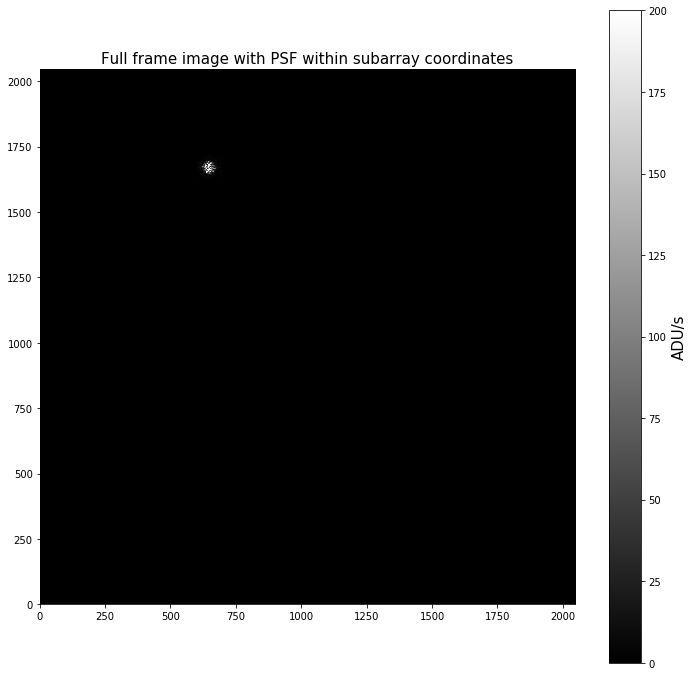

In [16]:
# Star 
fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(2048)
ys = range(2048)
xlabels = np.arange(0,2048)
ylabels = np.arange(0,2048)

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        

    
plt.imshow(star_big_array, vmin=0, vmax=200, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('Full frame image with target scene within subarray coordinates',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)


# PSF reference
fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(2048)
ys = range(2048)
xlabels = np.arange(0,2048)
ylabels = np.arange(0,2048)

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        

    
plt.imshow(psf_big_array, vmin=0, vmax=200, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('Full frame image with PSF within subarray coordinates',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)

### Now extract the subarray and save this subarray stamp image for use in the simulator

In [17]:
# For the star
star_out_array = np.zeros((subsize1,subsize2),dtype='float32')
star_out_array[:,:] = star_big_array[ystart:yend+1,xstart:xend+1]

star_imghdu = fits.PrimaryHDU(star_out_array)
star_imghdulist = fits.HDUList([star_imghdu])
star_imgname = star_base+"_seed_image.fits"
star_imghdulist.writeto(star_imgname, overwrite=True)

In [18]:
# For the PSF
psf_out_array = np.zeros((subsize1,subsize2),dtype='float32')
psf_out_array[:,:] = psf_big_array[ystart:yend+1,xstart:xend+1]

psf_imghdu = fits.PrimaryHDU(psf_out_array)
psf_imghdulist = fits.HDUList([psf_imghdu])
psf_imgname = psf_base+"_seed_image.fits"
psf_imghdulist.writeto(psf_imgname, overwrite=True)

In [19]:
print('\n')
print('Star image saved as: ',glob(star_imgname)[0])
print('PSF image saved as: ',glob(psf_imgname)[0])
print('\n')



Star image saved as:  Star_1planet_seed_image.fits
PSF image saved as:  PSF_ref_seed_image.fits




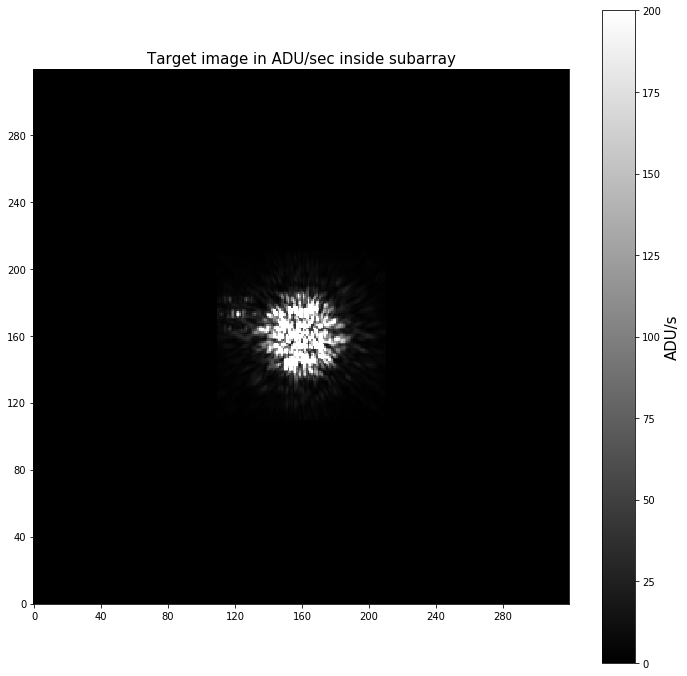

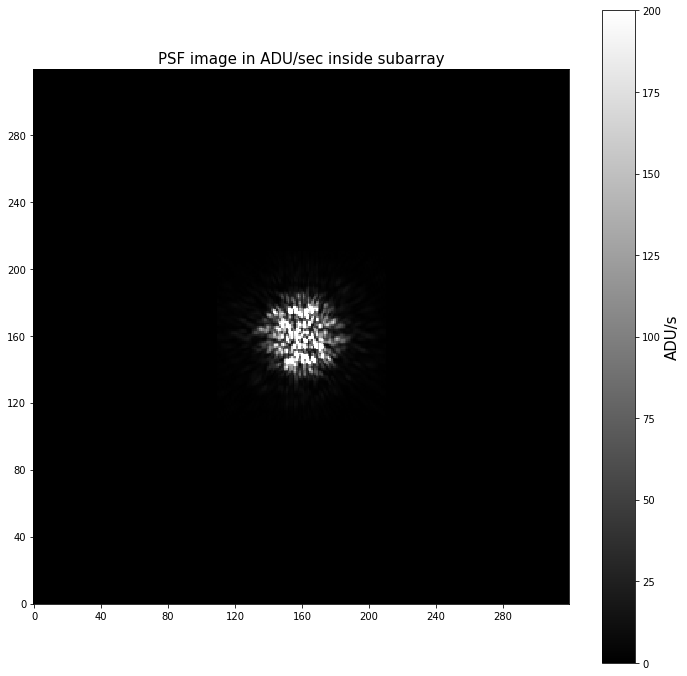

In [20]:
# Star
fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(2048)
ys = range(2048)
xlabels = np.arange(0,2048)
ylabels = np.arange(0,2048)

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        

    
plt.imshow(star_out_array, vmin=0, vmax=200, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('Target image in ADU/sec inside subarray',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)

# show(out_array,'Target image in ADU/sec inside subarray',max=200,unit='ADU')


# PSF
fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(2048)
ys = range(2048)
xlabels = np.arange(0,2048)
ylabels = np.arange(0,2048)

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        

    
plt.imshow(psf_out_array, vmin=0, vmax=200, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('PSF image in ADU/sec inside subarray',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)

# show(out_array,'Target image in ADU/sec inside subarray',max=200,unit='ADU')

### Now we begin the simulation. 

***
<a id='yaml'></a>
## 6. Use the JSON file to create the MIRAGE config files

MIRAGE simulations are controlled by the YAML configuration file. For convenience, this can be generated by MIRAGE using the APT pointing and xml files, but for simplicity here we update the configuration file information using the ETC output JSON file. Because the JSON file for the star and PSF reference are the same, we just use one YAML file
for both simulations. The input seed images are different.

In [21]:
# Use imaging_test.yaml parameter file as a template

template_fname = "imaging_test.yaml"
star_yaml_outname = star_base+"_json.yaml"
psf_yaml_outname = psf_base+"_json.yaml"


print(configuration['configuration']['detector']['subarray'])
print(configuration['configuration']['detector']['ngroup'])
print(configuration['configuration']['detector']['nint'])
print(configuration['configuration']['instrument']['aperture'])
print(configuration['configuration']['instrument']['filter'])

sub320
10
4
mask335r
f335m


### Parameter file for star simulation

In [22]:
with open(template_fname) as f:
    newdct = yaml.load(f)

# Instrument parameters    
newdct["Inst"]["use_JWST_pipeline"] = False

# Detector configuration parameters
newdct["Readout"] = {"readpatt": configuration['configuration']['detector']['readmode'].upper(),
                     "ngroup": configuration['configuration']['detector']['ngroup'],
                     "nint": configuration['configuration']['detector']['nint'],
                     "array_name": detector+"_"+mask.upper(),
                     "filter": configuration['configuration']['instrument']['filter'].upper(),
                     "pupil": "CLEAR"
                        }

# Reference file parameters
newdct["Reffiles"] = {"dark": "None",
                      "linearized_darkfile": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/darks/linearized/"+detector[-2:]+"/Linearized_Dark_and_SBRefpix_NRC"+detector[:4]+"LONG*.fits")[0],
                      "badpixmask": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/badpix/"+detector+"*DMSorient.fits")[0],
                      "superbias": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/superbias/"+detector+"_superbias_from_list_of_biasfiles.list.fits")[0],
                      "linearity": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/linearity/"+detector[:4]+"LONG_*DMSorient.fits")[0],
                      "saturation": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/saturation/"+detector+"_*DMSorient.fits")[0],
                      "gain": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/gain/"+detector+"*DMSorient.fits")[0],
                      "pixelflat": "None",
                      "illumflat": "None",
                      "astrometric": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/distortion/"+detector+"_FULL_distortion.asdf")[0],
                      "distortion_coeffs": "/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv",
                      "ipc": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/ipc/"+detector+"_*DMSorient.fits")[0],
                      "invertIPC": True,
                      "occult": "None" ,                            
                      "pixelAreaMap": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/pam/NIRCam_"+detector[-2:]+"_PAM_imaging.fits")[0],
                      "subarray_defs": "config",
                      "readpattdefs": "config",
                      "crosstalk": "config",
                      "filtpupilcombo": "config",
                      "flux_cal": "config",
                      "filter_throughput": "config"
                         }

# Cosmic ray parameters
newdct["cosmicRay"] = {
                      "path": "/ifs/jwst/wit/nircam/nircam_simulator_data/cosmic_ray_library/",
                      "library": "SUNMIN",
                      "scale": 1.5,
                      "suffix": "IPC_NIRCam_"+detector[-2:],
                      "seed": 2956411739
                          }

# Simulated signal parameters
newdct["simSignals"] = {
                      "pointsource": "None",
                      "psfpath": "/ifs/jwst/wit/nircam/nircam_simulator_data/webbpsf_library/",
                      "psfbasename": "nircam",
                      "psfpixfrac": 0.25,
                      "psfwfe": "predicted",
                      "psfwfegroup": 0,
                      "galaxyListFile": "None",
                      "extended": "None",
                      "extendedscale": 1.0,
                      "extendedCenter": "1024,1024",
                      "PSFConvolveExtended": True,
                      "movingTargetList": "None",
                      "movingTargetSersic": "None",
                      "movingTargetExtended": "None",
                      "movingTargetConvolveExtended": True,
                      "movingTargetToTrack": "None",
                      "zodiacal": "None",
                      "zodiscale": 1.0,
                      "scattered": "None",
                      "scatteredscale": 1.0,
                      "bkgdrate": "medium",
                      "poissonseed": 2012872553,
                      "photonyield": True,
                      "pymethod": True
                        }

# Telescope pointing parameters
newdct["Telescope"] = {
                      "ra": ra,
                      "dec": dec,
                      "rotation": rotation,
                      "tracking": "sidereal"
                        }

# Output file parameters    
newdct["Output"] = {
                      "file": star_base+"_MIRAGE_uncal.fits",
                      "directory": "./",
                      "datatype": "linear,raw",
                      "format": "DMS",
                      "save_intermediates": True,
                      "grism_source_image": False,
                      "unsigned": True,
                      "dmsOrient": True,
                      "program_number": "42424",
                      "title": "Test coronagraphy simulation",
                      "PI_Name": "A. Canipe",
                      "Proposal_category": "GO",
                      "Science_category": "Coronagraphy",
                      "observation_number": "002",
                      "observation_label": "Obs1",
                      "visit_number": "024",
                      "visit_group": "01",
                      "visit_id": "42424024002",
                      "sequence_id": "2",
                      "activity_id": "2o",
                      "exposure_number": "00001",
                      "obs_id": star_base,
                      "date_obs": "2019-10-15",
                      "time_obs": "06:29:11.852",
                      "obs_template": "NIRCam Imaging",
                      "primary_dither_type": "NONE",
                      "total_primary_dither_positions": 1,
                      "primary_dither_position": 1,
                      "subpix_dither_type": "2-POINT-MEDIUM-WITH-NIRISS",
                      "total_subpix_dither_positions": 2,
                      "subpix_dither_position": 2,
                      "xoffset": 344.284,
                      "yoffset": 466.768
                        }

# newdct

In [23]:
# Save out the new parameter file
with open(star_yaml_outname, "w") as f:
    yaml.dump(newdct, f)

### Parameter file for PSF reference

In [24]:
with open(template_fname) as f:
    newdct = yaml.load(f)

# Instrument parameters    
newdct["Inst"]["use_JWST_pipeline"] = False

# Detector configuration parameters
newdct["Readout"] = {"readpatt": configuration['configuration']['detector']['readmode'].upper(),
                     "ngroup": configuration['configuration']['detector']['ngroup'],
                     "nint": configuration['configuration']['detector']['nint'],
                     "array_name": detector+"_"+mask.upper(),
                     "filter": configuration['configuration']['instrument']['filter'].upper(),
                     "pupil": "CLEAR"
                        }

# Reference file parameters
newdct["Reffiles"] = {"dark": "None",
                      "linearized_darkfile": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/darks/linearized/"+detector[-2:]+"/Linearized_Dark_and_SBRefpix_NRC"+detector[:4]+"LONG*.fits")[0],
                      "badpixmask": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/badpix/"+detector+"*DMSorient.fits")[0],
                      "superbias": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/superbias/"+detector+"_superbias_from_list_of_biasfiles.list.fits")[0],
                      "linearity": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/linearity/"+detector[:4]+"LONG_*DMSorient.fits")[0],
                      "saturation": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/saturation/"+detector+"_*DMSorient.fits")[0],
                      "gain": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/gain/"+detector+"*DMSorient.fits")[0],
                      "pixelflat": "None",
                      "illumflat": "None",
                      "astrometric": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/distortion/"+detector+"_FULL_distortion.asdf")[0],
                      "distortion_coeffs": "/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv",
                      "ipc": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/ipc/"+detector+"_*DMSorient.fits")[0],
                      "invertIPC": True,
                      "occult": "None" ,                            
                      "pixelAreaMap": glob("/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/pam/NIRCam_"+detector[-2:]+"_PAM_imaging.fits")[0],
                      "subarray_defs": "config",
                      "readpattdefs": "config",
                      "crosstalk": "config",
                      "filtpupilcombo": "config",
                      "flux_cal": "config",
                      "filter_throughput": "config"
                         }

# Cosmic ray parameters
newdct["cosmicRay"] = {
                      "path": "/ifs/jwst/wit/nircam/nircam_simulator_data/cosmic_ray_library/",
                      "library": "SUNMIN",
                      "scale": 1.5,
                      "suffix": "IPC_NIRCam_"+detector[-2:],
                      "seed": 2956411739
                          }

# Simulated signal parameters
newdct["simSignals"] = {
                      "pointsource": "None",
                      "psfpath": "/ifs/jwst/wit/nircam/nircam_simulator_data/webbpsf_library/",
                      "psfbasename": "nircam",
                      "psfpixfrac": 0.25,
                      "psfwfe": "predicted",
                      "psfwfegroup": 0,
                      "galaxyListFile": "None",
                      "extended": "None",
                      "extendedscale": 1.0,
                      "extendedCenter": "1024,1024",
                      "PSFConvolveExtended": True,
                      "movingTargetList": "None",
                      "movingTargetSersic": "None",
                      "movingTargetExtended": "None",
                      "movingTargetConvolveExtended": True,
                      "movingTargetToTrack": "None",
                      "zodiacal": "None",
                      "zodiscale": 1.0,
                      "scattered": "None",
                      "scatteredscale": 1.0,
                      "bkgdrate": "medium",
                      "poissonseed": 2012872553,
                      "photonyield": True,
                      "pymethod": True
                        }

# Telescope pointing parameters
newdct["Telescope"] = {
                      "ra": ra,
                      "dec": dec,
                      "rotation": rotation,
                      "tracking": "sidereal"
                        }

# Output file parameters    
newdct["Output"] = {
                      "file": psf_base+"_MIRAGE_uncal.fits",
                      "directory": "./",
                      "datatype": "linear,raw",
                      "format": "DMS",
                      "save_intermediates": True,
                      "grism_source_image": False,
                      "unsigned": True,
                      "dmsOrient": True,
                      "program_number": "42424",
                      "title": "Test coronagraphy simulation",
                      "PI_Name": "A. Canipe",
                      "Proposal_category": "GO",
                      "Science_category": "Coronagraphy",
                      "observation_number": "002",
                      "observation_label": "Obs1",
                      "visit_number": "024",
                      "visit_group": "01",
                      "visit_id": "42424024002",
                      "sequence_id": "2",
                      "activity_id": "2o",
                      "exposure_number": "00001",
                      "obs_id": psf_base,
                      "date_obs": "2019-10-15",
                      "time_obs": "06:29:11.852",
                      "obs_template": "NIRCam Imaging",
                      "primary_dither_type": "NONE",
                      "total_primary_dither_positions": 1,
                      "primary_dither_position": 1,
                      "subpix_dither_type": "2-POINT-MEDIUM-WITH-NIRISS",
                      "total_subpix_dither_positions": 2,
                      "subpix_dither_position": 2,
                      "xoffset": 344.284,
                      "yoffset": 466.768
                        }

# newdct

In [25]:
# Save out the new parameter file
with open(psf_yaml_outname, "w") as f:
    yaml.dump(newdct, f)

***
<a id='seed'></a>
## 7. Initialize the seed images

Our seed image is the ETC output file mentioned in the previous section, however for easier calculations later we still run this step with our configurations. This should give us an empty image with only the background signal specified in the parameter file. Running the step with our configuration file to generate the image gives us access to the information contained in the seed image headers. 

In [26]:
star_cat = catalog_seed_image.Catalog_seed()
star_cat.paramfile = star_yaml_outname
star_cat.make_seed()

psf_cat = catalog_seed_image.Catalog_seed()
psf_cat.paramfile = psf_yaml_outname
psf_cat.make_seed()

'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/

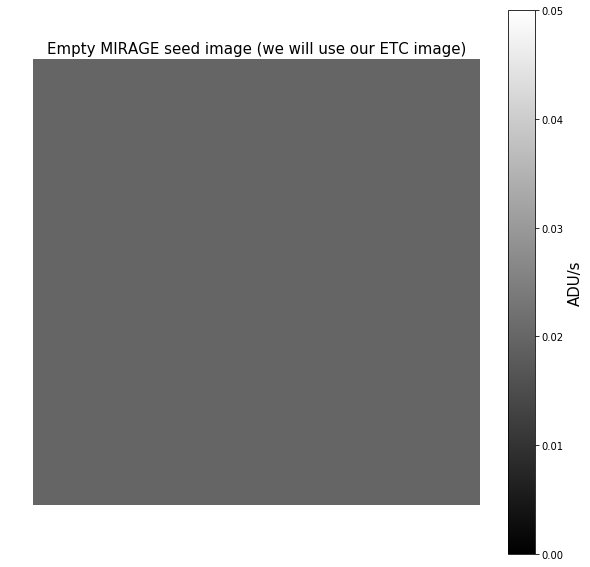

In [27]:
show(star_cat.seedimage,'Empty MIRAGE seed image (we will use our ETC image)',unit="ADU",max=0.05)

In [28]:
star_cat.seedinfo

{'xcenter': 160.0,
 'ycenter': 160.0,
 'units': 'ADU/sec',
 'TGROUP': 0.0,
 'filter': 'F335M',
 'PHOTFLAM': 2.9904e-21,
 'PHOTFNU': 1.1246e-30,
 'PHOTPLAM': 33578.0,
 'NOMXDIM': 320,
 'NOMYDIM': 320,
 'NOMXSTRT': 1.0,
 'NOMXEND': 320.0,
 'NOMYSTRT': 1.0,
 'NOMYEND': 320.0,
 'GRISMPAD': 1.4142135623730951}

***
<a id='dark'></a>
## 8. Prepare the dark current exposure

This will be the base of the simulated data. This step linearizes the dark current and reorganizes it into the requested readout pattern and number of groups.

In [29]:
star_d = dark_prep.DarkPrep()
star_d.paramfile = star_yaml_outname
star_d.prepare()

psf_d = dark_prep.DarkPrep()
psf_d.paramfile = psf_yaml_outname
psf_d.prepare()

'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/dq_init.cfg for newRamp:dq_configfile input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/

Averaging dark current ramp. Frames [8 9], to become group 4
Averaging dark current ramp. Frames [10 11], to become group 5
Averaging dark current ramp. Frames [12 13], to become group 6
Averaging dark current ramp. Frames [14 15], to become group 7
Averaging dark current ramp. Frames [16 17], to become group 8
Averaging dark current ramp. Frames [18 19], to become group 9
Averaging dark current ramp. Frames [0 1], to become group 0
Averaging dark current ramp. Frames [2 3], to become group 1
Averaging dark current ramp. Frames [4 5], to become group 2
Averaging dark current ramp. Frames [6 7], to become group 3
Averaging dark current ramp. Frames [8 9], to become group 4
Averaging dark current ramp. Frames [10 11], to become group 5
Averaging dark current ramp. Frames [12 13], to become group 6
Averaging dark current ramp. Frames [14 15], to become group 7
Averaging dark current ramp. Frames [16 17], to become group 8
Averaging dark current ramp. Frames [18 19], to become group 9
Aver

### Look at the dark current

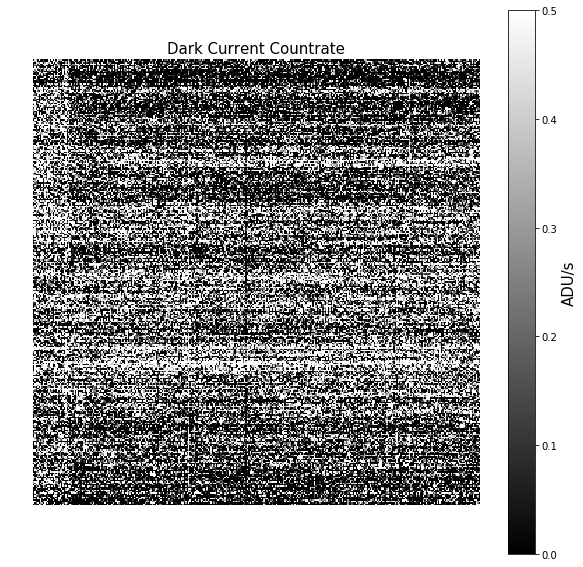

In [30]:
exptime = psf_d.linDark.header['NGROUPS'] * psf_cat.frametime
diff = (psf_d.linDark.data[0,-1,:,:] - psf_d.linDark.data[0,0,:,:]) / exptime
show(diff,'Dark Current Countrate',unit="ADU",max=0.5)

***
<a id='simulation'></a>
## 9. Create the final simulated exposures

This is where we substitute our modified ETC detector images (correct units, subarray stamp). We also substitute our configuration (YAML) file created in the previous steps. 

In [31]:
# Star
star_obs = obs_generator.Observation()
star_obs.linDark = star_d.prepDark
star_obs.seed = star_out_array             # our ETC seed image
star_obs.seedheader = star_cat.seedinfo
star_obs.paramfile = star_yaml_outname   # our configuration file
star_obs.create()

# PSF
psf_obs = obs_generator.Observation()
psf_obs.linDark = psf_d.prepDark
psf_obs.seed = psf_out_array             
psf_obs.seedheader = psf_cat.seedinfo
psf_obs.paramfile = psf_yaml_outname   
psf_obs.create()


Running observation generator....

'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/mirage-0.0.0.dev339+gb2e8f8ee-py3.6.egg/mirage/config/nircam_filter_pupil_pairings.list for Reffiles:filtpupilcombo input file
'config' specified: Using /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/s

PermissionError: [Errno 13] Permission denied: '/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/ipc/Kernel_to_add_IPC_effects_from_NRCA5_17158_IPCDeconvolutionKernel_2016-03-18_ssbipc_DMSorient.fits'

***
<a id='examine'></a>
## 10. Check out the simulated output linearized exposures

In [32]:
star_linfile = glob(star_base+'_MIRAGE_linear.fits')[0]
with fits.open(star_linfile) as h:
    star_lindata = h[1].data
    star_header = h[0].header
    
psf_linfile = glob(psf_base+'_MIRAGE_linear.fits')[0]
with fits.open(psf_linfile) as h:
    psf_lindata = h[1].data
    psf_header = h[0].header    

### Look at the difference image for the output linearized simulated exposure

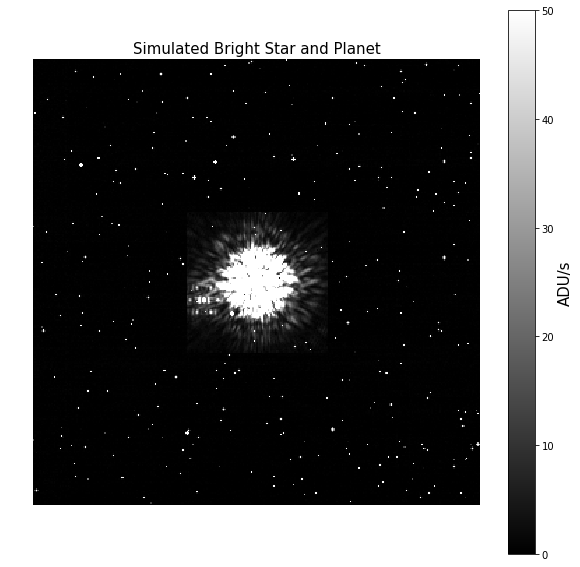

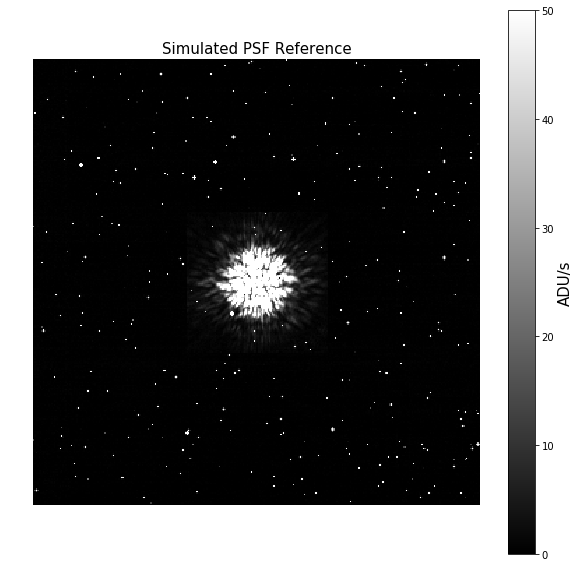

In [33]:
exptime = star_header['EFFINTTM']
star_diffdata = (star_lindata[0,-1,:,:] - star_lindata[0,0,:,:]) / exptime
show(star_diffdata,'Simulated Bright Star and Planet',min=0,max=50,unit='ADU')

psf_diffdata = (psf_lindata[0,-1,:,:] - psf_lindata[0,0,:,:]) / exptime
show(psf_diffdata,'Simulated PSF Reference',min=0,max=50,unit='ADU')

/Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


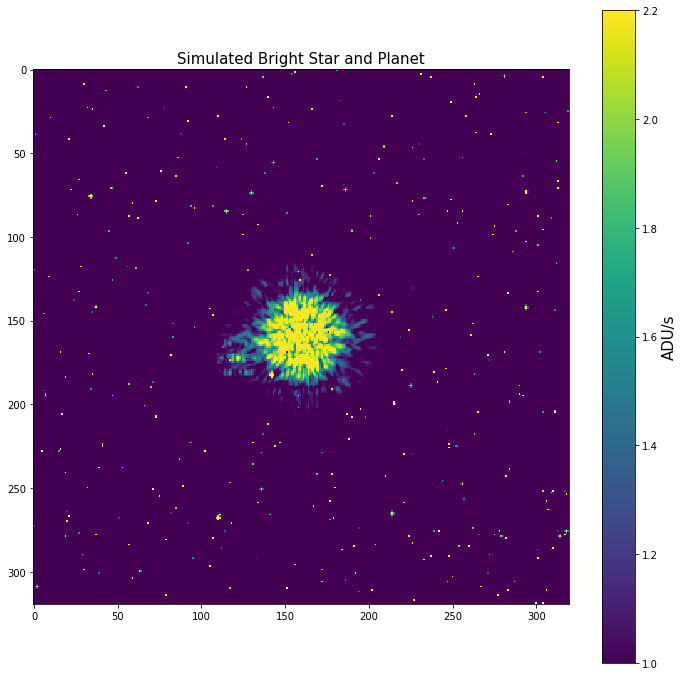

In [34]:
# Show on a log scale, to bring out the dark current
# Noise in the CDS image makes for a lot of pixels with values < 0,
# which makes this kind of an ugly image. Add an offset so that
# everything is positive and the noise is visible
offset = 2.
plt.figure(figsize=(12,12))
plt.imshow(np.log10(star_diffdata+offset),vmin=1,vmax=2.2)#,clim=(0.001,np.log10(80)))
plt.title('Simulated Bright Star and Planet',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)

***
<a id='pipeline'></a>
## 11. Use the Stage 1 pipeline to generate slope images

### Run the Data Quality Initialization, Saturation Check, and Superbias Subtraction steps

In [35]:
# The headers doesn't get populated correctly for coronagraphy, so we need to update it

star_rawfile = glob(star_base+'_MIRAGE_uncal.fits')[0]
with fits.open(star_rawfile) as h:
    h[0].header['SUBARRAY'] = subarray.upper()+detector[-2]+mask[4:].upper()
    h[0].header['EXP_TYPE'] = 'NRC_CORON'
    h[0].header['CORONMSK'] = mask.upper()
    h.writeto(star_rawfile,overwrite=True)
    
psf_rawfile = glob(psf_base+'_MIRAGE_uncal.fits')[0]
with fits.open(psf_rawfile) as h:
    h[0].header['SUBARRAY'] = subarray.upper()+detector[-2]+mask[4:].upper()
    h[0].header['EXP_TYPE'] = 'NRC_CORON'    
    h[0].header['CORONMSK'] = mask.upper()    
    h.writeto(psf_rawfile,overwrite=True)

In [36]:
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep

In [37]:
star_dq = DQInitStep.call(psf_rawfile)
star_sat = SaturationStep.call(star_dq)
star_sup = SuperBiasStep.call(star_sat)

psf_dq = DQInitStep.call(psf_rawfile)
psf_sat = SaturationStep.call(psf_dq)
psf_sup = SuperBiasStep.call(psf_sat)

2019-02-19 14:53:18,044 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2019-02-19 14:53:18,461 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('PSF_ref_MIRAGE_uncal.fits',).
2019-02-19 14:53:18,982 - stpipe.DQInitStep - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nircam_mask_0038.fits
2019-02-19 14:53:20,103 - stpipe.DQInitStep - WARNING - Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:53:20,218 - stpipe.DQInitStep - WARNING - Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:53:20,262 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2019-02-19 14:53:20,275 - stpipe.DQInitStep - INFO - Step DQInitStep done
2019-02-19 14:53:20,277 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2019-02-19 14:53:20,349 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(4, 10, 320, 320)

### Plot the group images up the ramp after subtracting off Group 0

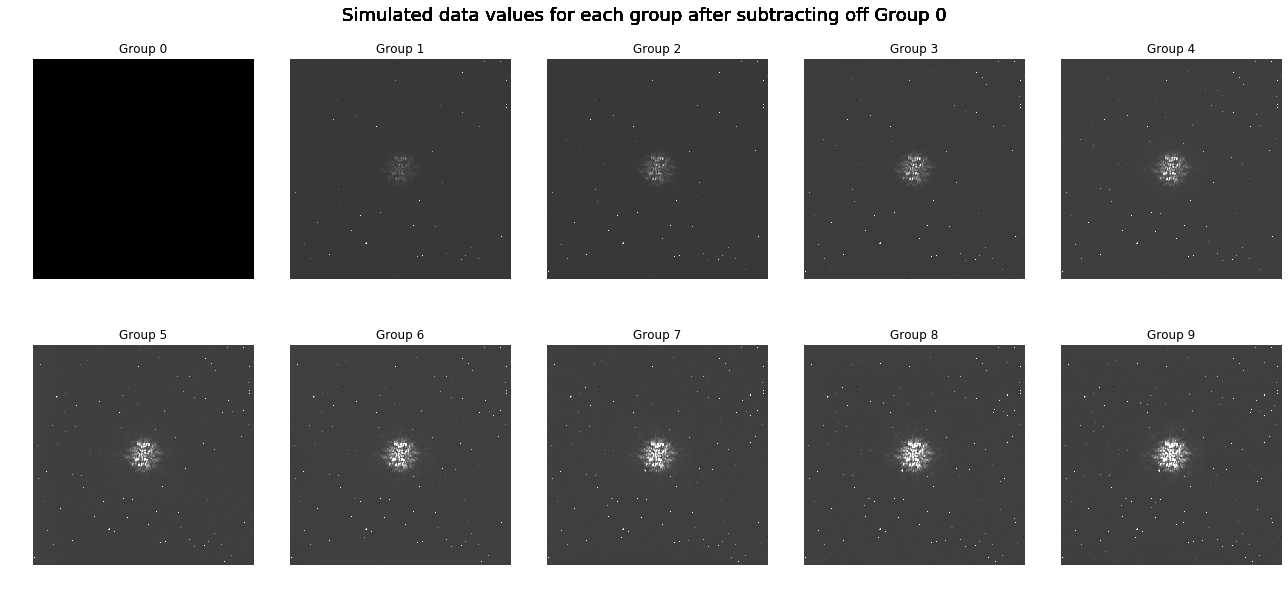

In [38]:
fig = plt.figure(figsize=(18,20))

for plotnums in range(1,len(np.arange(0,star_sup.data.shape[1]))+1):
    grpdata = star_sup.data[0,plotnums-1,:,:] - star_sup.data[0,0,:,:] 
    plot1 = fig.add_subplot(5,5,plotnums)
    plot1.imshow(grpdata,vmax=4000,cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title('Group '+str(plotnums-1))
    fig.text(0.5, 1.0, "Simulated data values for each group after subtracting off Group 0", ha='center', fontsize=18)    
    fig.tight_layout()    

### Plot some ramps for random pixels 

Text(0.5, 1.0, 'Random pixel values up the ramp for simulated exposure')

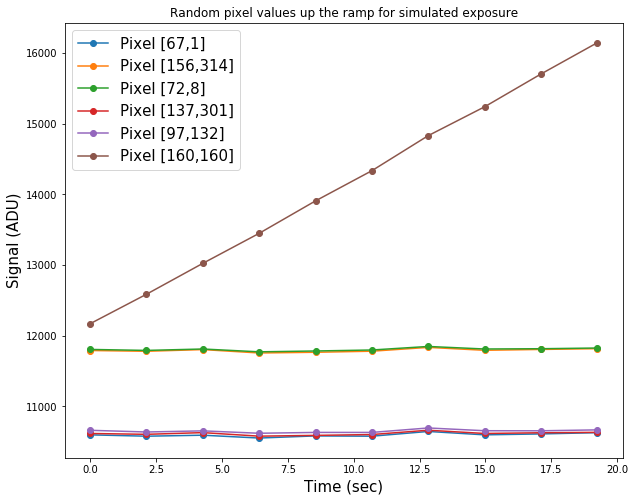

In [39]:
x = np.arange(0,star_sup.data.shape[1])*star_sup.meta.exposure.group_time
numpix = 5

fig = plt.figure(figsize=(10,8))
for i in np.arange(0,numpix):
    randx = random.randint(0,star_sup.data.shape[-1]-1)
    randy = random.randint(0,star_sup.data.shape[-2]-1)
    plt.plot(x,star_sup.data[0,:,randy,randx],marker='o',label='Pixel ['+str(randx)+','+str(randy)+']')
    plt.xlabel('Time (sec)',fontsize=15)
    plt.ylabel('Signal (ADU)',fontsize=15)
    plt.legend(fontsize=15)
plt.plot(x,star_sup.data[0,:,160,160],marker='o',label='Pixel ['+str(160)+','+str(160)+']')
plt.legend(fontsize=15)

plt.title('Random pixel values up the ramp for simulated exposure')

### Run the rest of the pipeline steps on the linearized output file to get the slope (count rate) images

In [40]:
# # Note that you could also do it this way:
# from jwst.refpix import RefPixStep
# from jwst.linearity import LinearityStep
# from jwst.jump import JumpStep
# from jwst.ramp_fitting import RampFitStep

# star_ref = RefPixStep.call(star_sup)
# star_lin = LinearityStep.call(star_ref)
# star_jump = JumpStep.call(star_lin)
# star_ramp = RampFitStep.call(star_jump,output_file=star_base+"_rate.fits")

# psf_ref = RefPixStep.call(psf_sup)
# psf_lin = LinearityStep.call(psf_ref)
# psf_jump = JumpStep.call(psf_lin)
# psf_ramp = RampFitStep.call(psf_jump,output_file=psf_base+"_rate.fits")

from jwst.pipeline import calwebb_detector1
pipe = calwebb_detector1.Detector1Pipeline()

# Skip non-NIRCam steps
pipe.group_scale.skip = True
pipe.ipc.skip = True
pipe.rscd.skip = True
pipe.firstframe.skip = True
pipe.lastframe.skip = True
pipe.dark_current.skip = True
pipe.persistence.skip = True
pipe.gain_scale.skip = True

# Change to NIRCam configs (not MIRI)
pipe.refpix.odd_even_rows = False

# Outputs
pipe.output_file = star_base+"_rate.fits"
pipe.run(star_rawfile)

# Outputs
pipe.output_file = psf_base+"_rate.fits"
pipe.run(psf_rawfile)

2019-02-19 14:54:18,201 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-19 14:54:18,202 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-19 14:54:18,204 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-02-19 14:54:18,206 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-02-19 14:54:18,207 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-02-19 14:54:18,209 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-02-19 14:54:18,211 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-19 14:54:18,213 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-19 14:54:18,215 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-19 14:54:18,216 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-02-19 

2019-02-19 14:54:21,237 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2019-02-19 14:54:21,237 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2019-02-19 14:54:21,238 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False
2019-02-19 14:54:21,316 - stpipe.Detector1Pipeline.refpix - WARNING - No valid reference pixels, refpix step skipped
2019-02-19 14:54:21,319 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-02-19 14:54:21,408 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(4, 10, 320, 320) from Star_1planet_MIRAGE_uncal.fits>,).
2019-02-19 14:54:21,436 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nircam_linearity_0052.fits
2019-02-19 14:54:23,793 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:54:23,794 - st

2019-02-19 14:55:18,474 - stpipe.Detector1Pipeline.gain_scale - INFO - Step skipped.
2019-02-19 14:55:18,475 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2019-02-19 14:55:18,829 - stpipe.Detector1Pipeline - INFO - Saved model in Star_1planet_rateints.fits
2019-02-19 14:55:18,830 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2019-02-19 14:55:19,080 - stpipe.Detector1Pipeline - INFO - Saved model in Star_1planet_rate.fits
2019-02-19 14:55:19,081 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2019-02-19 14:55:19,164 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('PSF_ref_MIRAGE_uncal.fits',).
2019-02-19 14:55:19,266 - stpipe.Detector1Pipeline - WARNING - /Users/jgirard/miniconda3/envs/mirage_osx/lib/python3.6/site-packages/jwst-0.12.0a0.dev134+g9fd36628-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening PSF_ref_MIRAGE_uncal.fits as a RampModel
  war

2019-02-19 14:55:21,209 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:55:21,210 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:55:21,210 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:55:21,212 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:55:21,213 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-19 14:55:21,265 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2019-02-19 14:55:21,340 - stpipe.Detector1Pipelin

<ImageModel(320, 320) from PSF_ref_rate.fits>

In [41]:
star_slopeimage = star_base+"_rate.fits"
star_slopeimage_integrations = star_base+"_rateints.fits"

psf_slopeimage = psf_base+"_rate.fits"
psf_slopeimage_integrations = psf_base+"_rateints.fits"

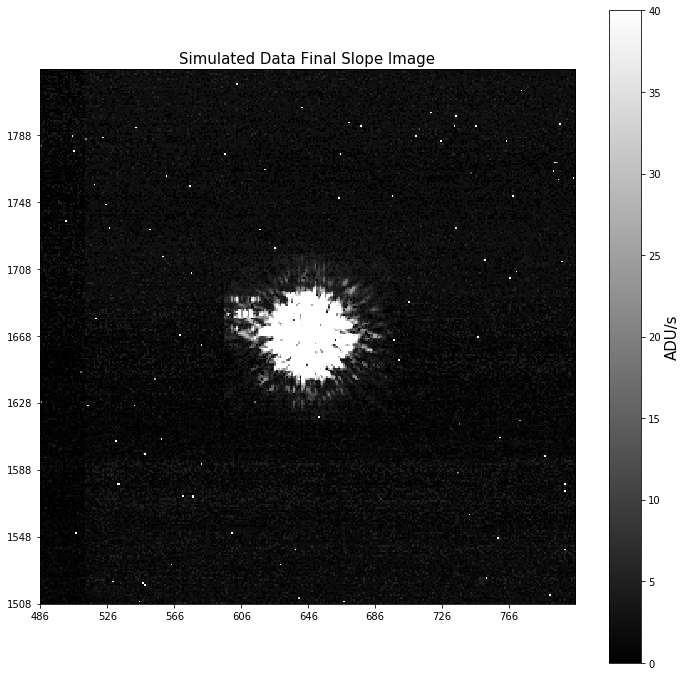

In [42]:
slopedata = fits.getdata(star_slopeimage,1)
hdr1 = fits.getheader(star_slopeimage,0)
hdr2 = fits.getheader(star_slopeimage,1)

fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(hdr2['NAXIS1'])
ys = range(hdr2['NAXIS2'])
xlabels = np.arange(hdr1['SUBSTRT1'],hdr1['SUBSTRT1']+hdr2['NAXIS1'])
ylabels = np.arange(hdr1['SUBSTRT2'],hdr1['SUBSTRT2']+hdr2['NAXIS2'])

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        


plt.imshow(slopedata, vmin=0, vmax=40, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('Simulated Data Final Slope Image',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)

***
<a id='stage2'></a>
## 12. Run Stage 2 steps on the Stage 1 outputs

The Stage 1 pipeline performs the detector level corrections and outputs a rate.fits image and a rateints.fits image. The rate.fits image contains countrates averaged over the integrations. The rateints.fits image contains countrates for each integration (the shape is 3D). Now, you want to run the rateints.fits exposure through Stage 2 processing before moving onto the coronagraphy (Stage 3) pipeline. 

**Note:** You can also supply an association table for Stage 2, but we don't do that here.

In [43]:
from jwst.pipeline import calwebb_image2
pipe = calwebb_image2.Image2Pipeline()


# Outputs
pipe.output_file = star_base+"_image2.fits"
pipe.run(star_slopeimage_integrations)

# Outputs
pipe.output_file = psf_base+"_image2.fits"
pipe.run(psf_slopeimage_integrations)

2019-02-19 15:00:18,450 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2019-02-19 15:00:18,452 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-02-19 15:00:18,455 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-02-19 15:00:18,457 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-02-19 15:00:18,458 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2019-02-19 15:00:18,461 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2019-02-19 15:00:18,545 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('Star_1planet_rateints.fits',).
2019-02-19 15:00:19,283 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'Star_1planet_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 

2019-02-19 15:00:24,515 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2019-02-19 15:00:24,515 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2019-02-19 15:00:24,515 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2019-02-19 15:00:24,516 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2019-02-19 15:00:24,516 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2019-02-19 15:00:24,517 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.
2019-02-19 15:00:24,517 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.
2019-02-19 15:00:24,518 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_nircam_photom_0051.fits'.
2019-02-19 15:00:24,519 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2019-02-19 15:00:24,519 - stpi

***
<a id='stage3'></a>
## 13. Run Stage 3 (coronagraphy pipeline) on the Stage 2 outputs

To run the Stage 3 pipeline for coronagraphy, you need to supply an association table. 

Read more about associations here: 
> https://jwst-docs.stsci.edu/display/JDAT/Understanding+Associations

> http://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/index.html

Association tables provide the relationships between multiple exposures and allow the user to identify a set of exposures that belong together and might be dependent on one another. 

An example association table is shown below: 


```python
{
    "asn_rule": "CORON", 
    "target": "None", 
    "asn_pool": "None", 
    "program": "None",
    "products": [
        {"prodtype": "coroncmb", 
         "name": "Star_1planet",
         "members": [
             {"exptype": "science", "expname": "Star_1planet_image2_calints.fits"},
             {"exptype": "psf", "expname": "PSF_ref_image2_calints.fits"}
           ]
        }
    ],
    "asn_type": "coron",
    "asn_id": "c1001"
}



```

You can also use the pipeline tool ```asn_from_list``` to create your association. ```asn_from_list``` is included in the pipeline code. To run it, provide your files and edit the exposure types afterwards. For example:

```python
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import json

asn = asn_from_list.asn_from_list(['Star_1planet_image2_calints.fits', 'PSF_ref_image2_calints.fits'], rule=DMS_Level3_Base, product_name='Star_1planet')
asn['products'][0]['members'][1]['exptype'] = 'psf'
with open('coron3_asn.json', 'w') as fh:
   fh.write(asn.dump()[1])
```

### Create the association file

In [44]:
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import json

asn = asn_from_list.asn_from_list([star_base+'_image2_calints.fits', psf_base+'_image2_calints.fits'], 
                                  rule=DMS_Level3_Base, product_name=star_base)
asn['products'][0]['members'][1]['exptype'] = 'psf'
with open('coron3_asn.json', 'w') as fh:
   fh.write(asn.dump()[1])

In [45]:
from jwst.pipeline import calwebb_coron3
pipe = calwebb_coron3.Coron3Pipeline()


# Outputs
pipe.output_file = star_base+"_image3.fits"
pipe.run("coron3_asn.json")

2019-02-19 15:01:15,275 - stpipe.Coron3Pipeline - INFO - Coron3Pipeline instance created.
2019-02-19 15:01:15,277 - stpipe.Coron3Pipeline.stack_refs - INFO - StackRefsStep instance created.
2019-02-19 15:01:15,279 - stpipe.Coron3Pipeline.align_refs - INFO - AlignRefsStep instance created.
2019-02-19 15:01:15,280 - stpipe.Coron3Pipeline.klip - INFO - KlipStep instance created.
2019-02-19 15:01:15,283 - stpipe.Coron3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-02-19 15:01:15,286 - stpipe.Coron3Pipeline.resample - INFO - ResampleStep instance created.
2019-02-19 15:01:15,370 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline running with args ('coron3_asn.json',).
2019-02-19 15:01:16,226 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'Star_1planet_image2_calints.fits' reftypes = ['drizpars', 'psfmask']
2019-02-19 15:01:16,231 - stpipe.Coron3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/

In [46]:
output_file = star_base+"_i2d.fits"

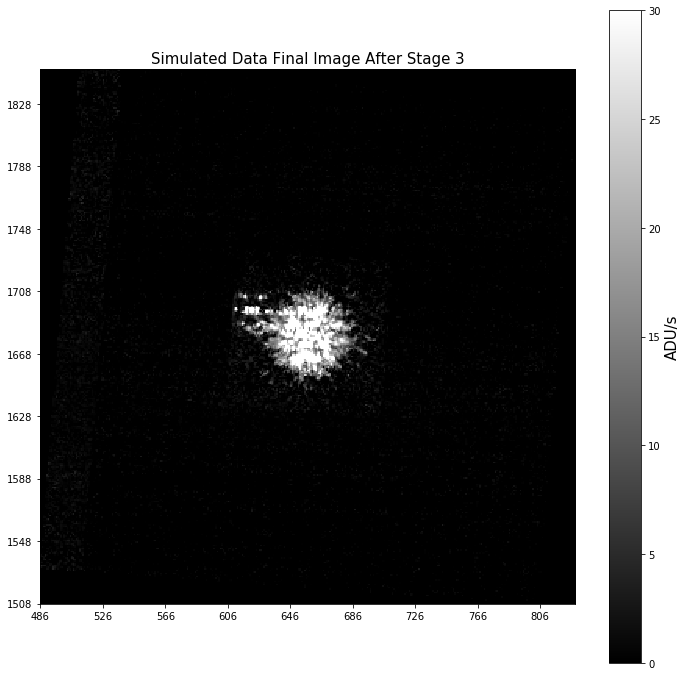

In [47]:
outputimage = fits.getdata(output_file,1)
hdr1 = fits.getheader(output_file,0)
hdr2 = fits.getheader(output_file,1)

fig, ax = plt.subplots(1,1,figsize=(12,12))

xs = range(hdr2['NAXIS1'])
ys = range(hdr2['NAXIS2'])
xlabels = np.arange(hdr1['SUBSTRT1'],hdr1['SUBSTRT1']+hdr2['NAXIS1'])
ylabels = np.arange(hdr1['SUBSTRT2'],hdr1['SUBSTRT2']+hdr2['NAXIS2'])

def format_fn_x(tick_val, tick_pos):
    if int(tick_val) in xs:
        return xlabels[int(tick_val)]
    else:
        return ''

def format_fn_y(tick_val, tick_pos):
    if int(tick_val) in ys:
        return ylabels[int(tick_val)]
    else:
        return ''    

ax.xaxis.set_major_formatter(FuncFormatter(format_fn_x))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(format_fn_y))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))        


plt.imshow(outputimage, vmin=0, vmax=30, origin='lower',cmap=plt.get_cmap('gray'))
plt.title('Simulated Data Final Image After Stage 3',fontsize=15)
plt.colorbar().set_label('ADU/s',size=15)